# Исследовательский анализ данных в Python и проверка гипотез.

## Анализ данных сервиса продажи онлайн-билетов

## Сбор и предобработка данных.
### Загрузка и объединение данных, проверка на пропуски.


In [1]:
#импортируем нужные библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu

In [2]:
#загружаем и просматриваем данные датасета
final_tickets_orders = pd.read_csv('https://link_to_df.csv')
final_tickets_orders.head(5)

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,service_name,tickets_count,total,days_since_prev
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,Край билетов,4,10870.99,NaN
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.45,Мой билет,2,2067.51,NaN
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.57,За билетом!,4,13984.16,75.0
3,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,нет,0,rub,mobile,8.49,Лови билет!,2,212.28,NaN
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.41,Билеты без проблем,3,10695.43,83.0


In [3]:
#смотрим пропуски
final_tickets_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290849 entries, 0 to 290848
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   order_id               290849 non-null  int64  
 1   user_id                290849 non-null  object 
 2   created_dt_msk         290849 non-null  object 
 3   created_ts_msk         290849 non-null  object 
 4   event_id               290849 non-null  int64  
 5   cinema_circuit         290849 non-null  object 
 6   age_limit              290849 non-null  int64  
 7   currency_code          290849 non-null  object 
 8   device_type_canonical  290849 non-null  object 
 9   revenue                290849 non-null  float64
 10  service_name           290849 non-null  object 
 11  tickets_count          290849 non-null  int64  
 12  total                  290849 non-null  float64
 13  days_since_prev        268909 non-null  float64
dtypes: float64(3), int64(4), object(7)
m

✅ Датасет содержит 14 столбцов и 290849 строк. Пропуски содержит только поле `days_since_prev`, что является органическим: у части пользователей может не быть предыдущих заказов. 

*Далее аналогичным образом загружены и просмотрены еще два датасета.*

Так как для дальнейшей работы нам понадобится объединенный датасет, а также валюта билетов должна быть переведена в рубли, произведем сразу объединение данных. Предобработку сделаем на объединенном датасете. 

In [8]:
#объединяем датасеты с заказами и мероприятиями 
final_all_1 = pd.merge(final_tickets_orders, final_tickets_events, how='left', on='event_id')

In [9]:
#присоединим датасета с курсом тенге к рублю
final_all = pd.merge(final_all_1, final_tickets_tenge, how='left', left_on='created_dt_msk', right_on='data')

In [10]:
#просмотрим итоговый датасет
final_all.head(5)

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,...,region_name,city_name,city_id,venue_id,venue_name,venue_address,data,nominal,curs,cdx
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,...,Каменевский регион,Глиногорск,213.0,3972.0,"Сценический центр ""Деталь"" Групп","алл. Машиностроителей, д. 19 стр. 6",2024-08-20,100,18.6972,kzt
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.45,...,Каменевский регион,Глиногорск,213.0,2941.0,"Музыкальная школа для детей ""Аккаунт"" Лтд","алл. Шмидта, д. 9 стр. 4",2024-07-23,100,18.3419,kzt
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.57,...,Каменевский регион,Глиногорск,213.0,4507.0,"Училище искусств ""Нирвана"" Инк","алл. Юбилейная, д. 5/6",2024-10-06,100,19.6475,kzt
3,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,нет,0,rub,mobile,8.49,...,Североярская область,Озёрск,2.0,3574.0,"Театр альтернативного искусства ""Ода"" Лимитед","алл. Есенина, д. 243 к. 3/8",2024-07-13,100,18.5010,kzt
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.41,...,Озернинский край,Родниковецк,240.0,1896.0,"Театр кукол ""Огни"" Инкорпорэйтед","ш. Набережное, д. 595 стр. 8",2024-10-04,100,19.6648,kzt


✅ Данные объединены, можно проводить предобработку.

### Преобразование форматов.


In [11]:
#проверяем типы данных
final_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290849 entries, 0 to 290848
Data columns (total 28 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   order_id                290849 non-null  int64  
 1   user_id                 290849 non-null  object 
 2   created_dt_msk          290849 non-null  object 
 3   created_ts_msk          290849 non-null  object 
 4   event_id                290849 non-null  int64  
 5   cinema_circuit          290849 non-null  object 
 6   age_limit               290849 non-null  int64  
 7   currency_code           290849 non-null  object 
 8   device_type_canonical   290849 non-null  object 
 9   revenue                 290849 non-null  float64
 10  service_name            290849 non-null  object 
 11  tickets_count           290849 non-null  int64  
 12  total                   290849 non-null  float64
 13  days_since_prev         268909 non-null  float64
 14  event_name          

**Итоговый датасет содержит 29 столбцов и и 290849 строк.**

Значительная доля пропусков (7,5%) есть только в столбце `days_since_prev`, что является органическим: у покупателя может не быть предыдущих покупок. Заменять на 0 в данном случае некорректно, так как данные уже содержат нули, которые означают, что повторная покупка была совершена в тот же день. Поэтому оставим эти пропуски как есть.

Также у части данных (менее 1%) после объединения отсутствует детальная информация о мероприятиях (название, город и тд), но так как этих пропусков очень мало, то никак обрабатывать их не будем.

По типам данным: в целом, столбцы имеют корректные типы данных, с которыми можно работать, но для корректности и оптимизации можно: 

* привести `created_dt_msk`и `created_dt_msk` к типам даты и времени,
* понизить разрядность у полей `age_limit`, `tickets_count`, `nominal`.

In [12]:
#преобразуем форматы 

final_all['created_dt_msk'] = pd.to_datetime(final_all['created_dt_msk'])
final_all['created_ts_msk'] = pd.to_datetime(final_all['created_ts_msk'])

final_all['age_limit'] = final_all['age_limit'].astype('int8')
final_all['tickets_count'] = final_all['tickets_count'].astype('int8')
final_all['nominal'] = final_all['nominal'].astype('int8')


In [13]:
#проверка преобразования
final_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290849 entries, 0 to 290848
Data columns (total 28 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   order_id                290849 non-null  int64         
 1   user_id                 290849 non-null  object        
 2   created_dt_msk          290849 non-null  datetime64[ns]
 3   created_ts_msk          290849 non-null  datetime64[ns]
 4   event_id                290849 non-null  int64         
 5   cinema_circuit          290849 non-null  object        
 6   age_limit               290849 non-null  int8          
 7   currency_code           290849 non-null  object        
 8   device_type_canonical   290849 non-null  object        
 9   revenue                 290849 non-null  float64       
 10  service_name            290849 non-null  object        
 11  tickets_count           290849 non-null  int8          
 12  total                   290849

###  Создание дополнительных столбцов для анализа. 


Далее создадим нужные для анализа и дальнейшей работы столбцы. 

In [14]:
#создаем столбец revenue_rub (выручка с заказа в рублях)
#напишем функцию, которая будет переводить тенге в рубли по соответствующему курсу 
def convert_currency(row):
    if row['currency_code'] == row['cdx']:
        return round(row['revenue'] / row['nominal'] * row['curs'], 2)
    else:
        return row['revenue']

#применяем построчно к нашему датасету
final_all['revenue_rub'] = final_all.apply(convert_currency, axis=1)

In [15]:
#создаем столбец one_ticket_revenue_rub (выручка с продажи одного билета)
final_all['one_ticket_revenue_rub'] = round(final_all['revenue_rub'] / final_all['tickets_count'],2)

In [16]:
#создаем столбец month (месяц оформления заказа)
final_all['month'] = final_all['created_dt_msk'].dt.month

In [17]:
#создаем столбец season (категории сезонности)
#напишем функцию, которая будет определять сезон в зависимости от номера месяца 
def seasons(row):
    if 3 <= row['month'] <= 5:
        return "весна"
    elif 6 <= row['month'] <= 8:
        return "лето"
    elif 9 <= row['month'] <= 11:
        return "осень"
    else:
        return "зима"
#применяем построчно к нашему датасету   
final_all['season'] = final_all.apply(seasons, axis=1)

In [18]:
#проверим результат
final_all.head()

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,...,venue_name,venue_address,data,nominal,curs,cdx,revenue_rub,one_ticket_revenue_rub,month,season
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,...,"Сценический центр ""Деталь"" Групп","алл. Машиностроителей, д. 19 стр. 6",2024-08-20,100,18.6972,kzt,1521.94,380.48,8,лето
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.45,...,"Музыкальная школа для детей ""Аккаунт"" Лтд","алл. Шмидта, д. 9 стр. 4",2024-07-23,100,18.3419,kzt,289.45,144.72,7,лето
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.57,...,"Училище искусств ""Нирвана"" Инк","алл. Юбилейная, д. 5/6",2024-10-06,100,19.6475,kzt,1258.57,314.64,10,осень
3,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,нет,0,rub,mobile,8.49,...,"Театр альтернативного искусства ""Ода"" Лимитед","алл. Есенина, д. 243 к. 3/8",2024-07-13,100,18.5010,kzt,8.49,4.24,7,лето
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.41,...,"Театр кукол ""Огни"" Инкорпорэйтед","ш. Набережное, д. 595 стр. 8",2024-10-04,100,19.6648,kzt,1390.41,463.47,10,осень


✅ Дополнительные столбцы созданы и добавлены в датасет.

### Проверка на явные и неявные дубликаты.


Теперь проверим значения категориальных полей датасета, нет ли там неявных дубликатов. 

In [21]:
#проверяем уникальные значения в поле с валютой
final_all['currency_code'].unique()

array(['rub', 'kzt'], dtype=object)

✅ В поле с валютой две категории: рубли и тенге.

*Аналогичным образом проверены остальные столбцы.*

In [24]:
#проверяем уникальные значения в поле с описанием мероприятий (плюс сортировка и удаление пропусков)
sorted (final_all['event_type_description'].dropna().unique())


['балет',
 'выставка',
 'концерт',
 'кукольный спектакль',
 'музыкальный спектакль',
 'мюзикл',
 'опера',
 'оперетта',
 'подарок',
 'рок-мюзикл',
 'снегурочка',
 'событие',
 'спектакль',
 'спорт',
 'спортивное мероприятие',
 'фестиваль',
 'цирковое шоу',
 'шоу',
 'экскурсия',
 'ёлка']

⚠️ В поле с описанием события обнаружены неявные дубликаты: спорт и спортивное мероприятие. Заменим их на общее название `спортивное мероприятие`.
Также есть вопросы к категориям: снегурочка и ёлка, но здесь есть сомнения в том, что это дубликаты, лучше уточнить этот вопрос у заказчика. 

In [25]:
#меняем название категорий
final_all['event_type_description'] = final_all['event_type_description'].replace({'спорт': 'спортивное мероприятие'})


Оставшиеся столбцы (такие как `city_name`, `venue_name`, `venue_address`) уже не являются категориальными, да и для анализа там не понадобятся, поэтому проверять неявные дубликаты в них не будем. 

Теперь проверим на явные дубликаты.

In [29]:
final_all.duplicated().sum()

0

✅ Явных дубликатов не обнаружено. 

Однако, помимо явных и неявных (в названиях категориальных полей) дубликатов, может присутствовать еще один тип дубликатов: когда данные о билетах задублировались, но по какой-то причине им присвоены разные order_id. То есть в таких строках совпадают все данные, кроме order_id. Проверим датасет на такие дубликаты:

In [30]:
final_all.duplicated(subset=final_all.columns.difference(['order_id']), keep=False).sum()

58

⚠️ Обнаружено 58 скрытых дубликатов. Удалим их, оставив только одно вхождение. 

In [31]:
final_all_clean = final_all.drop_duplicates(subset=final_all.columns.difference(['order_id']),keep='first')

In [32]:
final_all_clean.shape

(290819, 32)

Продолжим предобработку изучением количественных данных. 

###    Изучение количественных данных, оценка данных на выбросы, обработка.


Для анализа данных важными показателями являются **выручка с заказа revenue** и **количество билетов в заказе tickets_count**, поэтому проверим данные в этих столбцах. И так как мы уже провели преобразование данных в рубли, то анализировать будем поля `revenue_rub` и `tickets_count`.

In [33]:
#посмотрим описательную статистику по выручке
final_all_clean['revenue_rub'].describe()

count    290819.000000
mean        555.150649
std         875.309591
min         -90.760000
25%         113.400000
50%         350.330000
75%         802.050000
max       81174.540000
Name: revenue_rub, dtype: float64

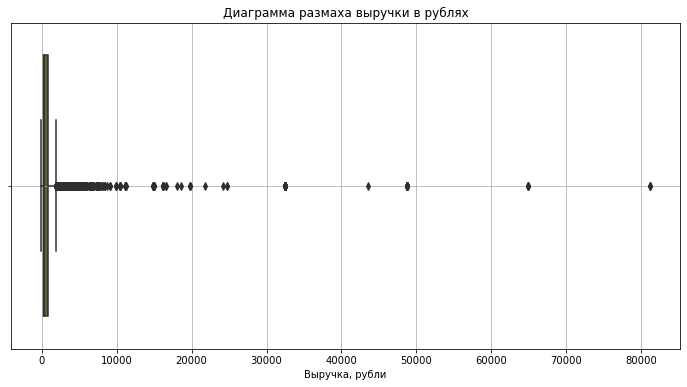

In [34]:
#визуализируем распределение выручки с помощью диаграммы размаха
plt.figure(figsize=(12, 6))
sns.boxplot(x=final_all_clean['revenue_rub'], color='#556B2F')

plt.title('Диаграмма размаха выручки в рублях')
plt.xlabel('Выручка, рубли')
plt.grid(True)
plt.show()

⚠️ Данные по выручке (в рублях): 

* содержат отрицательные значения (возможно, возвраты билетов) 
* содержат выбросы, среднее значение и медиана существенно отличаются (среднее 555 руб., медиана 350 руб., а стандартное отклонение 875 говорит о большом разбросе данных)
* диапазон распределения данных: от -91 руб. до 81175 руб. 

Разделим выручку на положительные и отрицательные значения, чтобы оценить размер этих групп. 

In [35]:
revenue_negative = final_all[final_all['revenue_rub'] < 0]['revenue_rub'].sum()
revenue_positive = final_all[final_all['revenue_rub'] > 0]['revenue_rub'].sum()

print (f'Возвратов: {revenue_negative} руб. , купленных билетов: {revenue_positive:.2f} руб.')

Возвратов: -949.59 руб. , купленных билетов: 161459365.83 руб.


Сумма возвратов ничтожно мала относительно общего объема выручки, поэтому можно эти данные отфильтровать. Также, отфильтруем данные по 99 процентилю, чтобы убрать выбросы с «правой» стороны. 
Но сначала изучим еще данные по количеству билетов в заказе.

In [36]:
#посмотрим описательную статистику по количеству билетов
final_all_clean['tickets_count'].describe()

count    290819.000000
mean          2.754256
std           1.170461
min           1.000000
25%           2.000000
50%           3.000000
75%           4.000000
max          57.000000
Name: tickets_count, dtype: float64

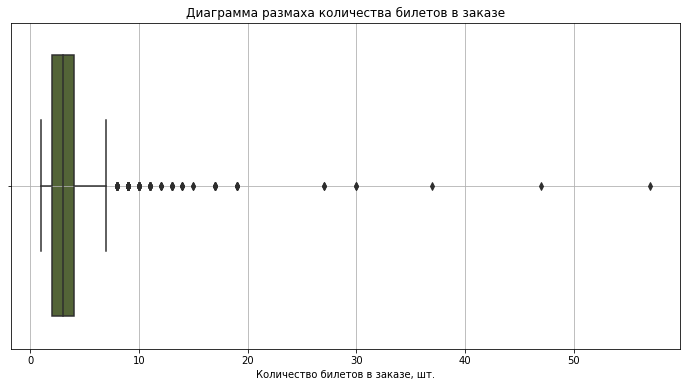

In [37]:
#визуализируем распределение количества билетов с помощью диаграммы размаха
plt.figure(figsize=(12, 6))
sns.boxplot(x=final_all_clean['tickets_count'],color='#556B2F')

plt.title('Диаграмма размаха количества билетов в заказе')
plt.xlabel('Количество билетов в заказе, шт.')
plt.grid(True)
plt.show()

⚠️ Среднее количество билетов – 2.75, медиана – 3, стандартное отклонение небольшое (1.17), значит, разброс не слишком сильный.
Но максимум 57 билетов за раз — это аномально высокое значение, возможно, массовая закупка или ошибка.
75-й процентиль равен 4, следовательно, 57 — это явный выброс по сравнению с основной массой данных.
Эти данные также отфильтруем по 99-му процентилю. 

In [38]:
#считаем 99-й процентиль по выручке
revenue_q99 = final_all_clean['revenue_rub'].quantile(0.99)
#считаем 99-й процентиль по количеству билетов
tickets_count_q99 = final_all_clean['tickets_count'].quantile(0.99)

#фильтруем данные, оставляя выручку больше 0 и меньше 99-го процентиля и количество билетов меньше 99-го процентиля включительно
final_filtered = final_all_clean[
    (final_all_clean['revenue_rub'] > 0) & 
    (final_all_clean['revenue_rub'] <= revenue_q99) &
    (final_all_clean['tickets_count'] <= tickets_count_q99)
]

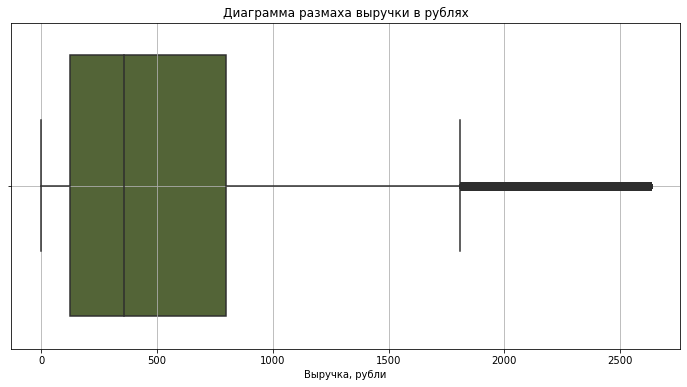

In [39]:
#визуализируем результат фильтрации: распределение выручки на диаграмме размаха
plt.figure(figsize=(12, 6))
sns.boxplot(x=final_filtered['revenue_rub'],color='#556B2F')

plt.title('Диаграмма размаха выручки в рублях')
plt.xlabel('Выручка, рубли')
plt.grid(True)
plt.show()

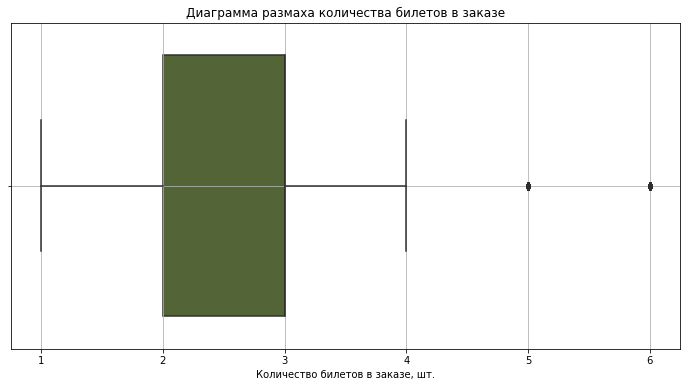

In [40]:
#визуализируем результат фильтрации: распределение количества билетов на диаграмме размаха
plt.figure(figsize=(12, 6))
sns.boxplot(x=final_filtered['tickets_count'], color='#556B2F')

plt.title('Диаграмма размаха количества билетов в заказе')
plt.xlabel('Количество билетов в заказе, шт.')
plt.grid(True)
plt.show()

In [41]:
print(f"Всего строк: {len(final_all)}, после фильтрации осталось: {len(final_filtered)} ({len(final_filtered) / len(final_all) * 100:.2f}%)")

Всего строк: 290849, после фильтрации осталось: 281703 (96.86%)


После удаления дубликатов и фильтрации выбросов датасет стал содержать 281703 заполненных строк (отфильтровано 3,14% данных).
Итого, в процессе предобработки:

* данные объединены в один датасет, 
* все данные приведены к единой валюте RUB (в соответствии с курсом тенге),
* созданы дополнительные столбцы для анализа: `one_ticket_revenue_rub`, `month`, `season`,
* преобразованы форматы данных (приведены к типу дата-время, снижена размерность),
* проверены и оценены пропуски в данных, 
* проверены и исправлены неявные дубликаты в категориальных данных,
* проверены явные и скрытые дубликаты (удалены),
* количественные данные проверены на выбросы и отфильтрованы. 


## Исследовательский анализ данных.

### Анализ распределения заказов по сегментам и их сезонных изменений.

💬 Для каждого месяца найдите количество заказов и визуализируйте результаты. Проверьте, фиксируется ли увеличение заказов от июня к ноябрю 2024 года.

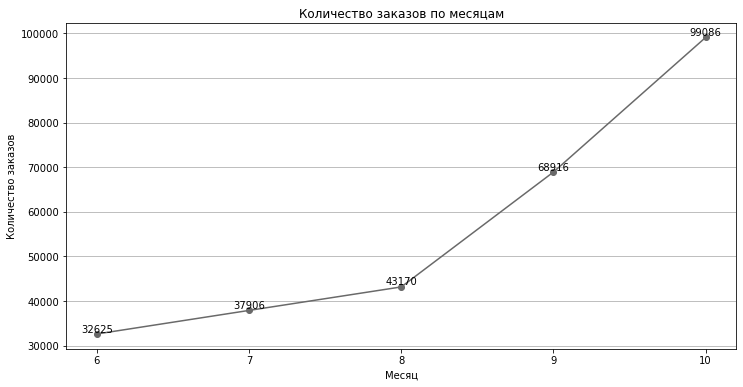

In [42]:
#группируем заказы по месяцам
orders_per_month = final_filtered.groupby('month')['order_id'].count()

#строим линейный график
plt.figure(figsize=(12, 6))
plt.plot(orders_per_month.index, orders_per_month.values, color='#696969', marker = 'o')
plt.title('Количество заказов по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Количество заказов')
plt.grid(axis='y')
plt.xticks(range(6, 11)) 
for i, v in enumerate(orders_per_month.values):
    plt.text(orders_per_month.index[i], v, str(v), ha='center', va='bottom')
plt.show()

Количество заказов растет от июня к октябрю 2024. В осенние месяцы количество заказов кратно отличается от летних.

💬 Для осеннего и летнего периодов сравните распределение заказов билетов по разным категориям: тип мероприятия, тип устройства, категория мероприятия по возрастному рейтингу.

In [43]:
#cоздаем сводную таблицу с количеством заказов, сгруппированным по типу мероприятия и сезону
orders_per_event_season = final_filtered.pivot_table(
    index='event_type_main',
    columns='season',
    values='order_id',
    aggfunc='count'
)

#считаем доли каждого мероприятия
orders_per_event_season_percent = round(orders_per_event_season.divide(orders_per_event_season.sum(axis=0), axis=1)*100,2).sort_values(by='лето', ascending=False)

#выводим таблицу на просмотр
display(orders_per_event_season_percent)


season,лето,осень
event_type_main,,
концерты,43.78,37.43
другое,25.00,19.40
театр,20.85,25.43
стендап,5.58,4.12
спорт,2.43,11.17
выставки,2.12,1.43
ёлки,0.24,1.01


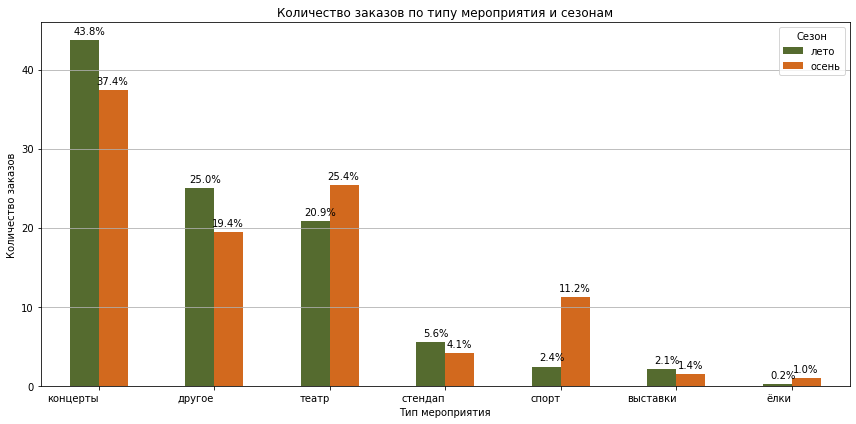

In [44]:
#задаем цветовую схему для диаграммы
colors = ['#556B2F', '#D2691E']
#строим гистограмму
ax = orders_per_event_season_percent.plot(kind='bar', figsize=(12, 6), color = colors)

#настройки графика
plt.title('Количество заказов по типу мероприятия и сезонам')
plt.xlabel('Тип мероприятия')
plt.ylabel('Количество заказов')
plt.legend(title='Сезон')
plt.xticks(rotation=0, ha='right')
plt.tight_layout()
plt.grid(axis='y')

#подписи данных
for i, row in enumerate(orders_per_event_season_percent.values):
    for j, val in enumerate(row):
        ax.text(i + j*0.2 - 0.08, val + 0.5, f'{val:.1f}%', ha='center', va='bottom')

#просмотр 
plt.show()

🔻 **Снижение количества заказов осенью**

И в летний, и в осенний период **лидер среди мероприятий – концерты**. Однако, осенью продажи билетов на концерты снижаются относительно лета. 
На втором месте мероприятия из категории «Другое», которые также снижают активность осенью, как «Стендап» и «Выставки». 

🔺 **Увеличение количества заказов осенью**

«Театр», «Спорт», «Ёлки» становятся популярнее с наступлением осени, что связано с факторами сезонности (такими как начало театрального сезона осенью, подготовка к новогодним ёлкам). 


In [45]:
#cоздаем сводную таблицу с количеством заказов, сгруппированным по типу устройства и сезону
orders_per_device_season = final_filtered.pivot_table(
    index='device_type_canonical',
    columns='season',
    values='order_id',
    aggfunc='count'
)

#считаем доли каждого устройства
orders_per_device_season_percent = round(orders_per_device_season.divide(orders_per_device_season.sum(axis=0), axis=1)*100,2).sort_values(by='лето', ascending=False)

#выводим таблицу на просмотр
display(orders_per_device_season_percent)


season,лето,осень
device_type_canonical,,
mobile,80.95,79.62
desktop,19.05,20.38


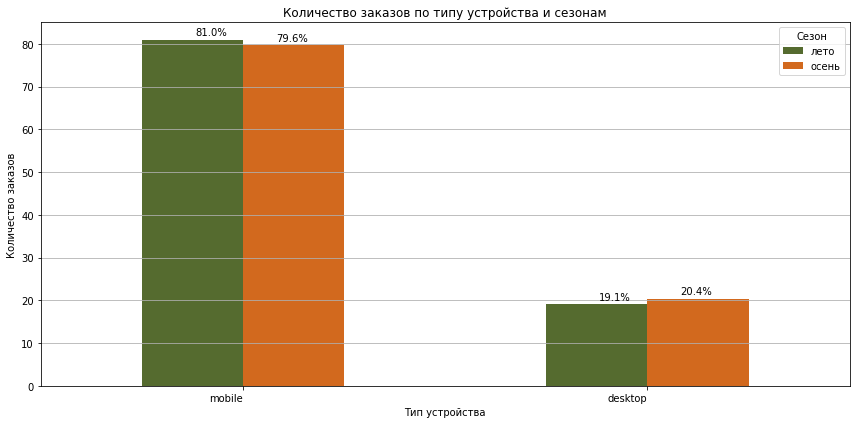

In [46]:
#строим гистограмму
ax1 = orders_per_device_season_percent.plot(kind='bar', figsize=(12, 6), color = colors)

#настройки графика
plt.title('Количество заказов по типу устройства и сезонам')
plt.xlabel('Тип устройства')
plt.ylabel('Количество заказов')
plt.legend(title='Сезон')
plt.xticks(rotation=0, ha='right')
plt.tight_layout()
plt.grid(axis='y')

#подписи данных
for i, row in enumerate(orders_per_device_season_percent.values):
    for j, val in enumerate(row):
        ax1.text(i + j*0.2 - 0.08, val + 0.5, f'{val:.1f}%', ha='center', va='bottom')

#просмотр 
plt.show()

Осенью по сравнению с летом:

🔻 меньше заказывают с мобильных устройств

🔺 больше заказывают с десктопов

Однако, доли изменились всего на 0.4%, поэтому можно считать, что фактор сезонности (лето/осень) слабо связан с устройствами пользователей. 

In [47]:
#cоздаем сводную таблицу с количеством заказов, сгруппированным по возрастному лимиту и сезону
orders_per_age_season = final_filtered.pivot_table(
    index='age_limit',
    columns='season',
    values='order_id',
    aggfunc='count'
)

#считаем доли каждого возрастного лимита
orders_per_age_season_percent = round(orders_per_age_season.divide(orders_per_age_season.sum(axis=0), axis=1)*100,2).sort_values(by='лето', ascending=False)

#выводим таблицу на просмотр
display(orders_per_age_season_percent)

season,лето,осень
age_limit,,
16,28.49,26.32
12,21.03,22.17
6,18.45,17.72
0,18.16,23.37
18,13.87,10.42


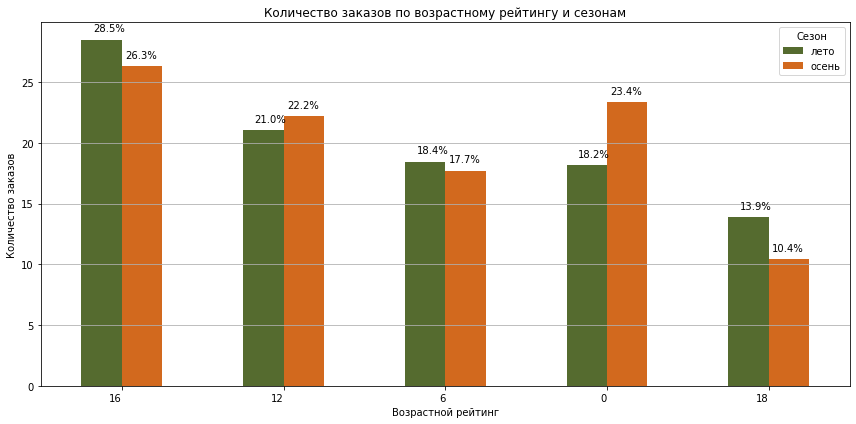

In [48]:
#строим гистограмму
ax2 = orders_per_age_season_percent.plot(kind='bar', figsize=(12, 6), color = colors)

#настройки графика
plt.title('Количество заказов по возрастному рейтингу и сезонам')
plt.xlabel('Возрастной рейтинг')
plt.ylabel('Количество заказов')
plt.legend(title='Сезон')
plt.xticks(rotation=0, ha='right')
plt.tight_layout()
plt.grid(axis='y')

#подписи данных
for i, row in enumerate(orders_per_age_season_percent.values):
    for j, val in enumerate(row):
        ax2.text(i + j*0.2 - 0.08, val + 0.5, f'{val:.1f}%', ha='center', va='bottom')

#просмотр 
plt.show()

🔺 **Увеличение количества заказов осенью**

0+ мероприятия (для всех возрастов, часто детские) заметно увеличили долю выручки осенью — с 18.16% до 23.37%.

Небольшой рост 12+, и стабильность 6+ также говорит о фокусе на детские мероприятия в осенний период.


🔻 **Снижение количества заказов осенью**

Мероприятия 16+ и 18+ осенью снизили долю.


Осенью структура выручки смещается в сторону мероприятий для детей и семейной аудитории (0+, 6+, 12+), тогда как взрослые категории (16+, 18+) теряют долю. 

💬 Изучите изменение выручки с продажи одного билета в зависимости от типа мероприятия летом и осенью. Видна ли динамика средней стоимости билета в разрезе разных категорий мероприятий?

In [49]:
#cоздаем сводную таблицу с выручкой с продажи одного билета, сгруппированным по типу мероприятия и сезону
one_ticket_rev_per_event_season = final_filtered.pivot_table(
    index='event_type_main',
    columns='season',
    values='one_ticket_revenue_rub',
    aggfunc='mean'
).sort_values(by='лето', ascending=False)

#считаем относительное изменение (осень относительно лета) в процентах
change = ((one_ticket_rev_per_event_season['осень'] - one_ticket_rev_per_event_season['лето']) / 
                   one_ticket_rev_per_event_season['лето']) * 100


#добавляем столбец с относительным изменением к исходной сводной таблице
one_ticket_rev_per_event_season['change_%'] = change

#функция, которая форматирует относительное изменение в зависимости от значения (больше или меньше 0)
def color_change(val):
    if pd.isna(val):
        return ''
    color = 'green' if val > 0 else 'red' if val < 0 else 'black'
    return f'color: {color}'

#вывод на экран с форматированием
display(one_ticket_rev_per_event_season.style.applymap(color_change, subset=['change_%']).format({'change_%': '{:.2f}', 'лето': '{:.2f}', 'осень': '{:.2f}'}))


season,лето,осень,change_%
event_type_main,,,
концерты,307.11,269.41,-12.28
ёлки,271.44,230.29,-15.16
стендап,218.59,231.47,5.89
театр,216.66,176.35,-18.60
другое,87.98,77.37,-12.06
выставки,86.74,91.90,5.95
спорт,55.23,50.26,-9.00


Средняя цена билета (и выручка, соответственно) по большинству категорий осенью снижается, что может указывать на смещение спроса в сторону более доступных и дешевых форматов.
Стендап и выставки — исключения, показывающие рост выручки с билета.

*Примечание. Не удалось придумать более подходящей визуализации, чем таблица. Возможно, стоило построить сгруппированную гистрограмму (для стоимости билетов лето/осени), и дополнить ее линейным графиков с %динамикой. Но, честно говоря, в таблице данные воспринимаются проще.*

**Общий вывод по сезонным изменениям лето/осень 2024:**

* происходит перераспределение категорий мероприятий: осенью больше покупают билетов в театр и на спортивные мероприятия, тем самым снижая долю заказов в категориях с концертами, стендапами и прочими мероприятиями. 

* в сегменте устройств пользователей не наблюдается существенных сезонных изменений: пользователи покупают билеты с мобильных/десктопов примерно одинаково. 

* осенью происходит смещение в сторону семейных/детских мероприятий (в категориях 0+, 6+, 12+), а доля взрослых мероприятий снижается. 

* средняя цена билетов по большинству категорий осенью снижается, что возможно объясняется тем, что семейные мероприятия стоят дешевле (например, билеты в кино стоят дешевле билетов на концерт). 

### Анализ активности пользователей осенью 2024 года.

💬 Изучите активность пользователей осенью 2024 года.
Проанализируйте динамику изменений по дням для:

* общего числа заказов;
* количества активных пользователей DAU;
* среднего числа заказов на одного пользователя;
* средней стоимости одного билета.

In [50]:
#фильтруем данные для осеннего сезона
final_filtered_autumn = final_filtered[final_filtered['season'] == "осень"]

#создаем сводную таблицу с необходимыми показателями, переименовываем столбцы
autumn_activity_per_days = final_filtered_autumn.pivot_table(
    index='created_dt_msk',
    values=['order_id', 'user_id', 'total', 'one_ticket_revenue_rub'],
    aggfunc={
        'order_id': 'count',
        'user_id': 'nunique',
        'one_ticket_revenue_rub': 'mean'}).rename(columns={
    'order_id': 'orders',
    'user_id': 'unique_users',
    'one_ticket_revenue_rub': 'avg_one_ticket_revenue'})

#округляем до 2 знаков после запятой 
autumn_activity_per_days['avg_one_ticket_revenue'] = autumn_activity_per_days['avg_one_ticket_revenue'].round(2)

#добавляем столбец: среднее количество заказов на пользователя
autumn_activity_per_days['orders_per_user'] = round((autumn_activity_per_days['orders'] / autumn_activity_per_days['unique_users']),2)

#выводим результат
display(autumn_activity_per_days.head())



,avg_one_ticket_revenue,orders,unique_users,orders_per_user
created_dt_msk,,,,
2024-09-01,203.67,1318,556,2.37
2024-09-02,190.85,1370,571,2.40
2024-09-03,80.87,5091,776,6.56
2024-09-04,179.86,1758,683,2.57
2024-09-05,190.39,1937,739,2.62


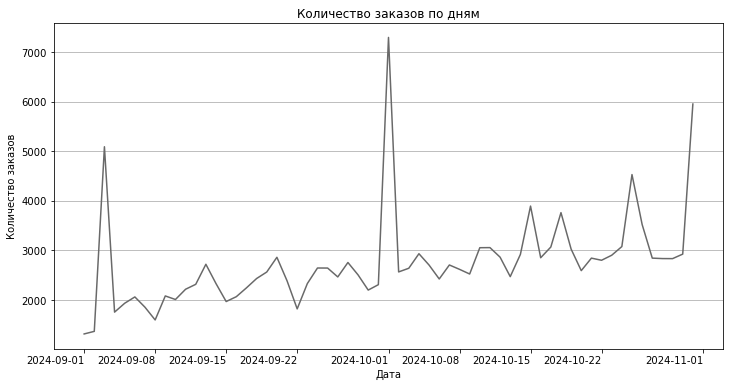

In [51]:
#построим линейный график: количество заказов по дням
plt.figure(figsize=(12, 6))
plt.plot(autumn_activity_per_days.index, autumn_activity_per_days['orders'], color='#696969')

plt.title('Количество заказов по дням')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.grid(axis='y')
plt.xticks(rotation=0, ha='right')

plt.show()


Количество заказов в течение осенних месяцев растет. В данных есть три пика, но в целом метрика показывает плавный рост от ~2000 до ~3000 заказов в день. 

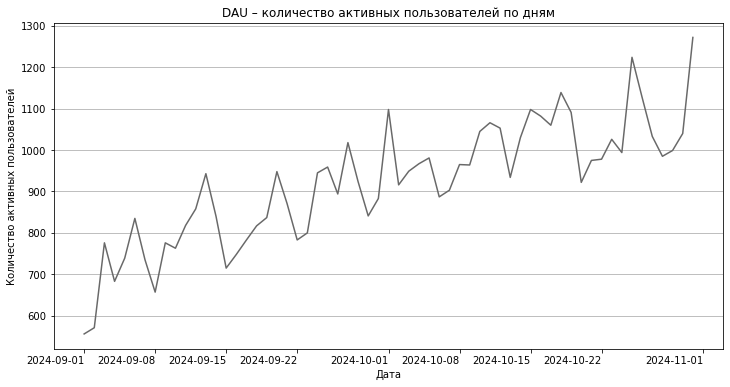

In [52]:
#построим линейный график: DAU
plt.figure(figsize=(12, 6))
plt.plot(autumn_activity_per_days.index, autumn_activity_per_days['unique_users'], color='#696969')

plt.title('DAU – количество активных пользователей по дням')
plt.xlabel('Дата')
plt.ylabel('Количество активных пользователей')
plt.grid(axis='y')
plt.xticks(rotation=0, ha='right')

plt.show()

Количество активных пользователей в день (DAU) выросло: c ~700 пользователей в начале сентября до ~1000-1200 в конце октября. Рост устойчивый, но показатель меняется скачкообразно. 

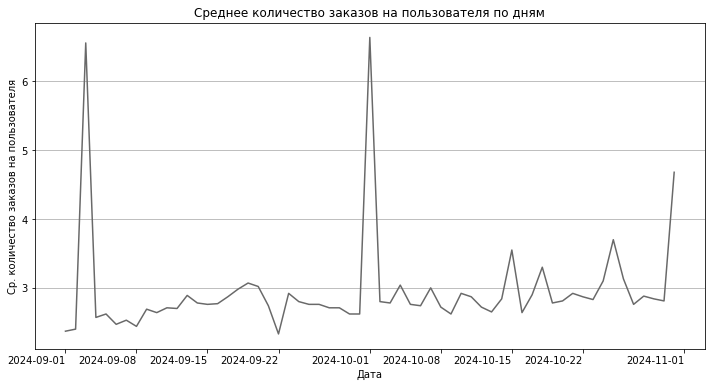

In [53]:
#построим линейный график: среднее число заказов на пользователя
plt.figure(figsize=(12, 6))
plt.plot(autumn_activity_per_days.index, autumn_activity_per_days['orders_per_user'], color='#696969')

plt.title('Среднее количество заказов на пользователя по дням')
plt.xlabel('Дата')
plt.ylabel('Ср. количество заказов на пользователя')
plt.grid(axis='y')
plt.xticks(rotation=0, ha='right')

plt.show()

Метрика среднего количество заказов пользователя в течение всего осеннего периода колеблется вокруг значения 3. Данные содержат три аномальных пика, но в остальном всё стабильно, с небольшим увеличением к концу периода.

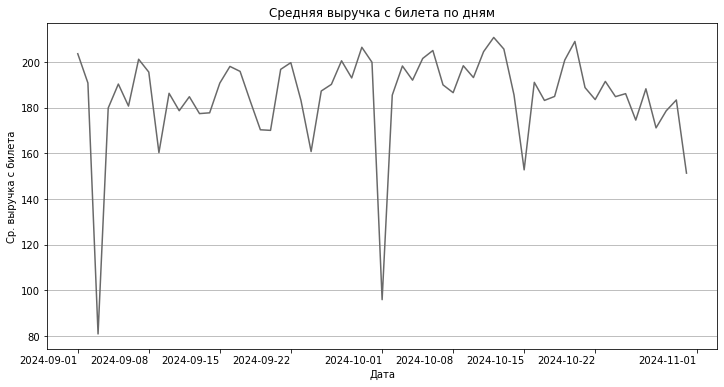

In [54]:
#построим линейный график: средняя стоимость билета
plt.figure(figsize=(12, 6))
plt.plot(autumn_activity_per_days.index, autumn_activity_per_days['avg_one_ticket_revenue'], color='#696969')

plt.title('Средняя выручка с билета по дням')
plt.xlabel('Дата')
plt.ylabel('Ср. выручка с билета')
plt.grid(axis='y')
plt.xticks(rotation=0, ha='right')

plt.show()

При этом метрика средняя выручка с билета по дням демонстрирует динамику, обратную количеству заказов пользователей. Данные также содержат три аномальных пика в те же даты, но в минус. Возможно, в эти дни была какая-то акция на покупку билетов. Значения колеблются вокруг 180-200 рублей с небольшим уменьшением к концу периода. 
Больше заказов ≠ больше выручка на билет.

💬 Изучите недельную цикличность. Выделите день недели и сравните пользовательскую активность в будни и выходные.

Пользовательская активность может быть охарактеризована двумя метриками: количество заказов и количество активных пользователей, посмотрим обе. 

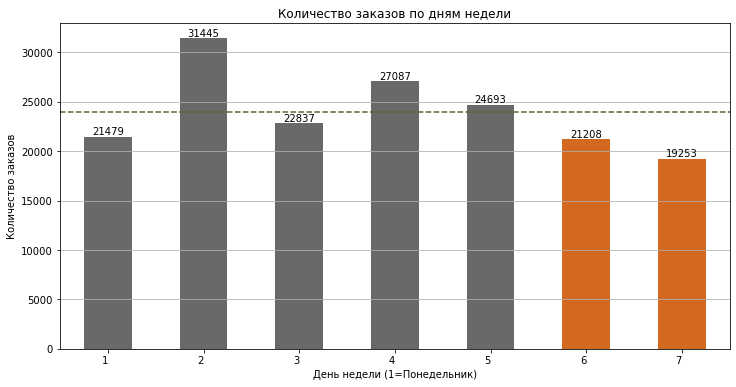

In [55]:
#добавим столбец с номером дня недели, начиная с 1 (понедельник)
final_filtered_autumn = final_filtered_autumn.copy()
final_filtered_autumn['day_name'] = final_filtered_autumn['created_dt_msk'].dt.weekday + 1

#посчитаем количество заказов по дням недели
orders_per_day_of_week = final_filtered_autumn.groupby('day_name')['order_id'].count()

#напишем функцию, которая будет окрашивать на диаграмме столбцы с буднями/выходными в разные цвета
def color_dayweek(val):
    if val == 6 or val == 7:
        color = '#D2691E'  
    else:
        color = '#696969' 
    return color

#создадим цветовую схему для диаграммы, применив пользовательскую функцию color_dayweek
colors2 = [color_dayweek(day) for day in orders_per_day_of_week.index]

#строим столбчатую диаграмму
ax = orders_per_day_of_week.plot(kind='bar', figsize=(12, 6), color=colors2)

#добавляем линию со средним значением заказов
mean_orders = orders_per_day_of_week.mean()
ax.axhline(mean_orders, color='#556B2F', linestyle='--', label=f'Среднее: {mean_orders:.1f}')

#добавляем подписи над столбцами
for i, val in enumerate(orders_per_day_of_week.values):
    ax.text(i, val + 0.5, str(val), ha='center', va='bottom')

#настраиваем и выводим диаграмму
plt.title('Количество заказов по дням недели')
plt.xlabel('День недели (1=Понедельник)')
plt.ylabel('Количество заказов')
plt.xticks(rotation=0, ha='right')
plt.grid(axis='y')

plt.show()



Самое высокое количество заказов – во вторник. 

Самое низкое – в воскресенье. 

Среднее количество заказов находится на уровне ~24 000. Во вторник, четверг и пятницу заказывают больше среднего, в остальные дни – меньше. 

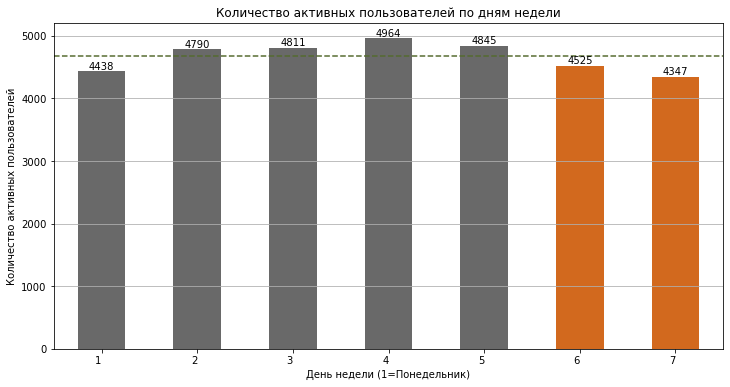

In [56]:
#посчитаем количество активных пользователей по дням недели
users_per_day_of_week = final_filtered_autumn.groupby('day_name')['user_id'].nunique()

#строим столбчатую диаграмму
ax2 = users_per_day_of_week.plot(kind='bar', figsize=(12, 6), color=colors2)

#добавляем линию со средним значением заказов
mean_users = users_per_day_of_week.mean()
ax2.axhline(mean_users, color='#556B2F', linestyle='--', label=f'Среднее: {mean_users:.1f}')

#добавляем подписи над столбцами
for i, val in enumerate(users_per_day_of_week.values):
    ax2.text(i, val + 0.5, str(val), ha='center', va='bottom')

#настраиваем и выводим диаграмму
plt.title('Количество активных пользователей по дням недели')
plt.xlabel('День недели (1=Понедельник)')
plt.ylabel('Количество активных пользователей')
plt.xticks(rotation=0, ha='right')
plt.grid(axis='y')

plt.show()

Самое высокое количество активных пользователей – во четверг.

Самое низкое – в воскресенье.

Среднее количество активных пользователей находится на уровне ~4 700. Во вторник, среду, четверг и пятницу заказывают больше среднего, в остальные дни – меньше.

**Общий вывод по осенней активности пользователей**

Осенний сезон 2024 года характеризуется устойчивым ростом пользовательской активности на платформе:

* Количество заказов стабильно растёт — с ~2000 до ~3000 заказов в день.

* Количество активных пользователей (DAU) увеличилось почти вдвое: с ~700 в начале сентября до ~1000-1200 в конце октября. 

* Среднее число заказов на одного пользователя сохраняется на уровне около 3, с небольшим ростом к концу периода. 

* Средняя выручка с билета, в целом стабильна, но демонстрирует небольшую нисходящую динамику. На те же даты, когда наблюдаются пики заказов, приходятся и минимумы по выручке на билет — вероятно, это связано с акциями или скидками.

Недельная цикличность:

* Активность пользователей по дням недели распределяется неравномерно.

* Максимум заказов и активных пользователей приходится на будние дни, минимум — на выходные. Это указывает на ярко выраженную цикличность: в будни (особенно в середине недели) пользователи более активны, чем в выходные.



### Популярные события и партнёры.

💬 Для каждого региона посчитайте уникальное количество мероприятий и общее число заказов. В каких регионах предлагается наибольшее разнообразие мероприятий?

In [57]:
#создаем сводную таблицу с необходимыми показателями, переименовываем столбцы
region_orders_events = final_filtered_autumn.pivot_table(
    index='region_name',
    values=['order_id', 'event_id'],
    aggfunc={
        'order_id': 'count',
        'event_id': 'nunique',
    }
).rename(columns={
    'order_id': 'orders',
    'event_id': 'events'
})

#добавляем столбцы с долями (в %)
region_orders_events['events_%'] = region_orders_events['events'] / region_orders_events['events'].sum() * 100
region_orders_events['orders_%'] = region_orders_events['orders'] / region_orders_events['orders'].sum() * 100

#сортируем по количеству мероприятий
region_orders_events = region_orders_events.sort_values(by='events', ascending=False)

#добавляем форматирование в стиле heatmap
region_orders_events.style.background_gradient(subset=['orders_%', 'events_%'], cmap='YlOrBr').format({'orders_%': '{:.2f}', 'events_%': '{:.2f}'})


,events,orders,events_%,orders_%
region_name,,,,
Каменевский регион,3897,46600,24.71,27.74
Североярская область,2594,20571,16.45,12.25
Широковская область,794,8645,5.03,5.15
Светополянский округ,755,4751,4.79,2.83
Речиновская область,529,3565,3.35,2.12
Серебринская область,456,4470,2.89,2.66
Яблоневская область,431,4195,2.73,2.50
Тепляковская область,419,2486,2.66,1.48
Горицветская область,406,3231,2.57,1.92


Абсолютный лидер и по количеству мероприятий, и по количеству заказов – **Каменевский регион**. На его долю приходится 28% всех мероприятий и заказов. 
Также в тройку лидеров входят Североярская область и Широковская область (по количеству мероприятий)/Медовская область (по количеству заказов). 

💬 Для каждого билетного партнёра посчитайте общее число уникальных мероприятий, обработанных заказов и суммарную выручку с заказов билетов. Сделайте акцент на наиболее активных партнёрах.

In [58]:
#создаем сводную таблицу с необходимыми показателями, переименовываем столбцы
service_orders_events_revenue = final_filtered_autumn.pivot_table(
    index='service_name',
    values=['order_id', 'event_id','revenue_rub'],
    aggfunc={
        'order_id': 'count',
        'event_id': 'nunique',
        'revenue_rub':'sum'
    }
).rename(columns={
    'order_id': 'orders',
    'event_id': 'events',
    'revenue_rub': 'total_revenue'
})

#добавляем столбцы с долями (в %)
service_orders_events_revenue['events_%'] = service_orders_events_revenue['events'] / service_orders_events_revenue['events'].sum() * 100
service_orders_events_revenue['orders_%'] = service_orders_events_revenue['orders'] / service_orders_events_revenue['orders'].sum() * 100
service_orders_events_revenue['revenue_%'] = service_orders_events_revenue['total_revenue'] / service_orders_events_revenue['total_revenue'].sum() * 100


#сортируем  по количеству мероприятий
service_orders_events_revenue = service_orders_events_revenue.sort_values(by='events', ascending=False)

#добавляем форматирование в стиле heatmap
service_orders_events_revenue.style.background_gradient(subset=['orders_%', 'events_%', 'revenue_%'], cmap='YlOrBr').format({'orders_%': '{:.2f}', 'events_%': '{:.2f}','revenue_%': '{:.2f}'})

,events,orders,total_revenue,events_%,orders_%,revenue_%
service_name,,,,,,
Лови билет!,3586,25718,10412266.100000,20.85,15.31,12.65
Билеты без проблем,2819,32100,12459130.950000,16.39,19.11,15.14
Билеты в руки,2447,25544,7620097.500000,14.23,15.20,9.26
Облачко,1409,15478,10611051.690000,8.19,9.21,12.89
Лучшие билеты,1377,12342,1672813.640000,8.01,7.35,2.03
Мой билет,1003,19403,10842032.510000,5.83,11.55,13.17
Тебе билет!,858,3765,2181787.800000,4.99,2.24,2.65
Прачечная,728,5798,2548310.470000,4.23,3.45,3.10
Весь в билетах,600,9427,9379748.640000,3.49,5.61,11.40


**Наиболее активные партнёры по доле рынка:**

**1. Лови билет!**

* Доля мероприятий: 20.85% (самая высокая)
* Доля заказов: 15.31%
* Доля выручки: 12.65%

Самый активный по количеству мероприятий. Однако, несмотря на большой объём событий, приносит относительно меньшую долю выручки — возможно, работает с недорогими билетами.

**2. Билеты без проблем**

* Доля мероприятий: 16.39%
* Доля заказов: 19.11% (лидер по заказам)
* Доля выручки: 15.14% (лидер по выручке)

Наиболее эффективный партнёр: лидирует как по количеству заказов, так и по выручке. 

**3. Билеты в руки**

* Доля мероприятий: 14.23%
* Доля заказов: 15.20%
* Доля выручки: 9.26%

Довольно активный по событиям и заказам, но заметно уступает по выручке. 

**4. Облачко**

* Доля мероприятий: 8.19%
* Доля заказов: 9.21%
* Доля выручки: 12.89%

Отличается высокой выручкой относительно своей активности — скорее всего, работает с более дорогими билетами или премиум-сегментом.

**5. Мой билет**

* Доля мероприятий: 5.83%
* Доля заказов: 11.55%
* Доля выручки: 13.17%

Эффективный игрок: относительно небольшая доля мероприятий, но высокая доля заказов и особенно выручки. 

В сегментах по регионам и билетным партнерам есть явные лидеры. И там, и там на топ-5 приходится более 50% мероприятий. 

В рейтинге регионов лидеры по мероприятиям и заказам почти совпадают. 
В рейтинге билетных партнеров наблюдается разнообразие: топы по мероприятиям, заказам и выручке не совпадают однозначно. 

## Статистический анализ данных и проверка гипотез.

### Проверка гипотезы о разнице среднего количества заказов на одного пользователя между мобильным приложением и стационарными устройствами.

💬 Проверьте две гипотезы, которые предполагают большую активность пользователей мобильных устройств:

Среднее количество заказов на одного пользователя мобильного приложения выше по сравнению с пользователями стационарных устройств.

Среднее время между заказами пользователей мобильных приложений выше по сравнению с пользователями стационарных устройств.

Для проверки гипотез сформируем две выборки: для мобильных и стационарных устройств, и изучим их перед проведением теста.

In [59]:
#выделяем из общего датафрейма группы по устройствам
mobile = final_filtered_autumn[final_filtered_autumn['device_type_canonical'] == 'mobile']
desktop = final_filtered_autumn[final_filtered_autumn['device_type_canonical'] == 'desktop']

#считаем количество пользователей в каждой группе
mobile_users = mobile['user_id'].nunique()
desktop_users = desktop['user_id'].nunique()

print (f'С мобильного приложения сделали заказы {mobile_users} пользователей, со стационарных устройств: {desktop_users} пользователей')

С мобильного приложения сделали заказы 14111 пользователей, со стационарных устройств: 4866 пользователей


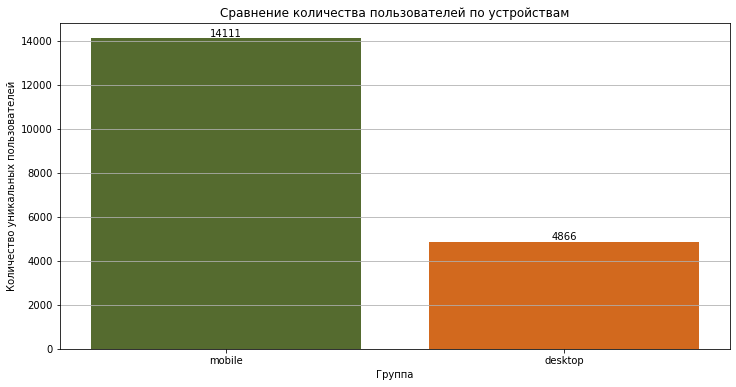

In [60]:
#строим столбчатую диаграмму по количеству пользователей в группах
plt.figure(figsize=(12, 6))

groups = ['mobile', 'desktop']
values = [mobile_users, desktop_users]

for i, v in enumerate(values):
    plt.text(i, v, str(v), ha='center', va='bottom')

plt.bar(groups, values, color=['#556B2F', '#D2691E'])
plt.title('Сравнение количества пользователей по устройствам')
plt.xlabel('Группа')
plt.ylabel('Количество уникальных пользователей')
plt.grid(axis = 'y')
plt.show()

Видим, что наши данные содержат неравномерное распределение между устройствами: со стационарных устройств покупает существенно меньше пользователей (почти втрое). Это не помешает нам проверить гипотезу, но предварительно нужно проверить группы на независимость и нормальное распределение. 

In [61]:
#проверяем пересечение множеств
intersection = set(mobile['user_id'].unique()) & set(desktop['user_id'].unique())

print(f"Пользователи, попавшие в обе группы: {len(intersection)}")

Пользователи, попавшие в обе группы: 3236


⚠️ Ой-ой... Пользователи, делающие заказы с мобильных и десктопов, сильно пересекаются. Для корректности теста нам нужны непересекающиеся множества, поэтому придется удалить пересекающихся пользователей. Это очень сильно понизит количество данных в выборке, но зато будет гарантировать корректность теста, хоть и с  пониженной мощностью из-за малого числа пользователей в одной из групп.

In [62]:
#удаляем пересекающихся пользователей 
mobile_clean = mobile[~mobile['user_id'].isin(intersection)]
desktop_clean = desktop[~desktop['user_id'].isin(intersection)]

In [63]:
#проверяем пересечение множеств после очистки
intersection = set(mobile_clean['user_id'].unique()) & set(desktop_clean['user_id'].unique())

print(f"Пользователи, попавшие в обе группы: {len(intersection)}")

Пользователи, попавшие в обе группы: 0


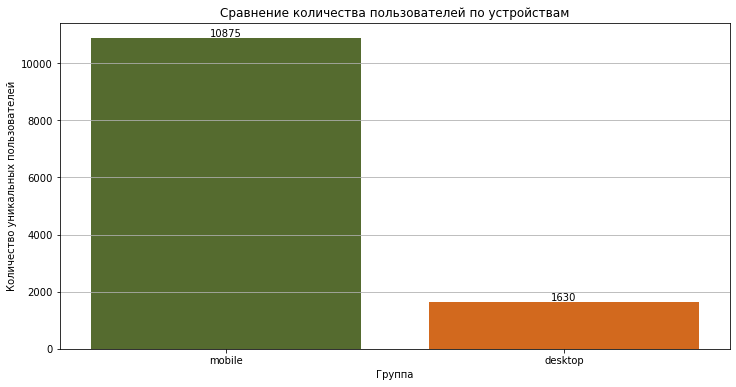

In [64]:
#строим столбчатую диаграмму по количеству пользователей в группах
plt.figure(figsize=(12, 6))

groups = ['mobile', 'desktop']
values = [mobile_clean['user_id'].nunique(), desktop_clean['user_id'].nunique()]

for i, v in enumerate(values):
    plt.text(i, v, str(v), ha='center', va='bottom')

plt.bar(groups, values, color=['#556B2F', '#D2691E'])
plt.title('Сравнение количества пользователей по устройствам')
plt.xlabel('Группа')
plt.ylabel('Количество уникальных пользователей')
plt.grid(axis = 'y')
plt.show()

Неравномерность в размере групп стала еще больше, но выборки независимы. 

Сформулируем гипотезы: 

**H0: Среднее количество заказов на одного пользователя не больше для мобильного приложения и стационарных устройств.**

**Н1: Среднее количество заказов на одного пользователя больше для мобильного приложения, чем для стационарных устройств.**

Создадим метрики, необходимые для проверки гипотезы.

In [65]:
#группируем количество заказов по пользователям для мобильных и десктопных заказов
mobile_orders = mobile_clean.groupby('user_id')['order_id'].count()
desktop_orders = desktop_clean.groupby('user_id')['order_id'].count()

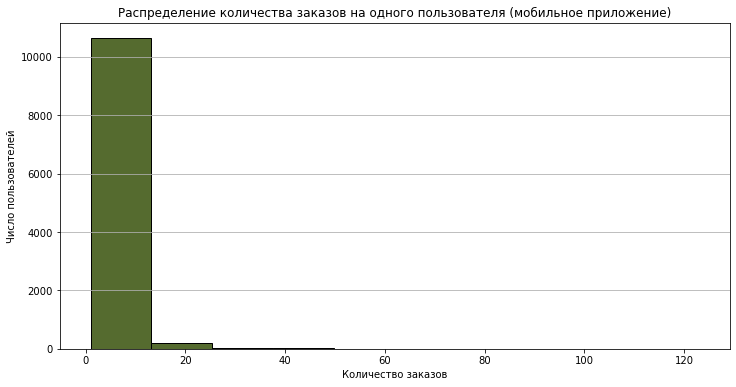

In [66]:
#строим гистограмму распределения
plt.figure(figsize=(12, 6))
plt.hist(mobile_orders, bins=10, color='#556B2F', edgecolor='black')
plt.title('Распределение количества заказов на одного пользователя (мобильное приложение)')
plt.xlabel('Количество заказов')
plt.ylabel('Число пользователей')
plt.grid(axis='y')
plt.show()

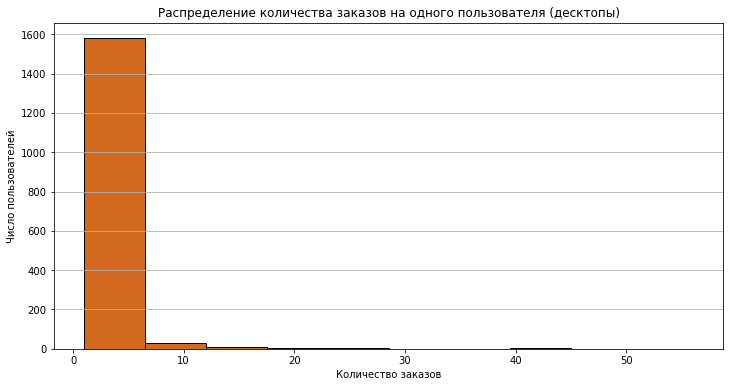

In [67]:
#строим гистограмму распределения
plt.figure(figsize=(12, 6))
plt.hist(desktop_orders, bins=10, color='#D2691E', edgecolor='black')
plt.title('Распределение количества заказов на одного пользователя (десктопы)')
plt.xlabel('Количество заказов')
plt.ylabel('Число пользователей')
plt.grid(axis='y')
plt.show()

Оба распределения пользователей сильно скошены вправо, не являются нормальными распределениями и имеют выбросы. Основная масса значений находится в интервале в от 0 до 10 заказов. С увеличением количества заказов количество пользователей резко падает. Наблюдаются редкие случаи большого количества заказов (40-50), что является выбросом. 

По результатам изучения данных было выявлено, **что выборки содержат выбросы и не подлежат нормальному распределению**, а значит, для проверки гипотезы будем использовать непараметрический тест Манна-Уитни.

In [68]:
# на каком уровне значимости проверяем гипотезу о равенстве распределений
alpha = 0.05 

mobile_orders = mobile_clean.groupby('user_id')['order_id'].count()
desktop_orders = desktop_clean.groupby('user_id')['order_id'].count()

# применяем тест Манна — Уитни
stat_mw, p_value_mw = mannwhitneyu(
    mobile_orders, 
    desktop_orders, 
    alternative='greater' 
) 

if p_value_mw > alpha:
    print(f'pvalue={p_value_mw} > {alpha}')
    print('Нулевая гипотеза находит подтверждение!')
else:
    print(f'pvalue={p_value_mw} < {alpha}')
    print('Нулевая гипотеза не находит подтверждения!')

pvalue=3.0044708534596875e-40 < 0.05
Нулевая гипотеза не находит подтверждения!


По результатам проведенного теста есть основания полагать, что среднее количество заказов на одного пользователя **действительно больше для мобильного приложения**, чем для стационарных устройств.

### Проверка гипотезы о разницы среднего времени между заказами пользователей мобильного приложения и стационарных устройств.

Среднее время между заказами хранится в столбце `days_since_prev`, который содержит пропуски данных. Для проверки гипотезы удалим пропуски:

In [69]:
#считаем пропуски в датасете
mobile_clean['days_since_prev'].isna().sum()

6631

In [70]:
#считаем пропуски в датасете
desktop_clean['days_since_prev'].isna().sum()

1122

In [71]:
#удаляем пропуски
mobile_clean = mobile_clean.dropna(subset=['days_since_prev'])
desktop_clean = desktop_clean.dropna(subset=['days_since_prev'])

Сформулируем гипотезы:

**H0: Среднее время между заказами не больше для мобильного приложения и стационарных устройств.**

**Н1: Среднее время между заказами больше для мобильного приложения, чем для стационарных устройств.**


Создадим метрики, необходимые для проверки гипотезы.

In [72]:
#считаем среднее время между заказами с группировкой по пользователям для мобильных и десктопов 
mobile_days_since_prev = mobile_clean.groupby('user_id')['days_since_prev'].mean()
desktop_days_since_prev = desktop_clean.groupby('user_id')['days_since_prev'].mean()

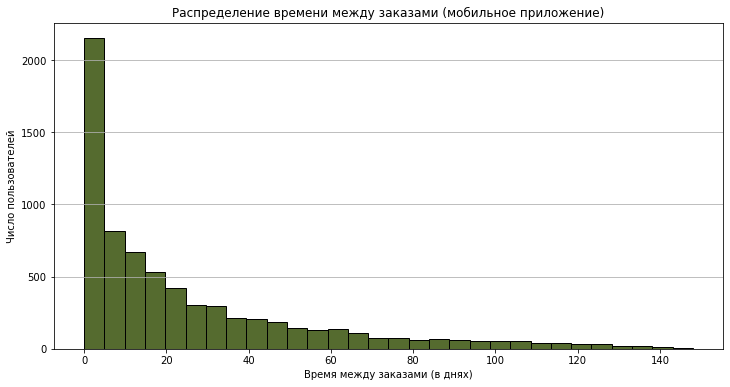

In [73]:
#строим гистограмму распределения
plt.figure(figsize=(12, 6))
plt.hist(mobile_days_since_prev, bins=30, color='#556B2F', edgecolor='black')
plt.title('Распределение времени между заказами (мобильное приложение)')
plt.xlabel('Время между заказами (в днях)')
plt.ylabel('Число пользователей')
plt.grid(axis='y')
plt.show()

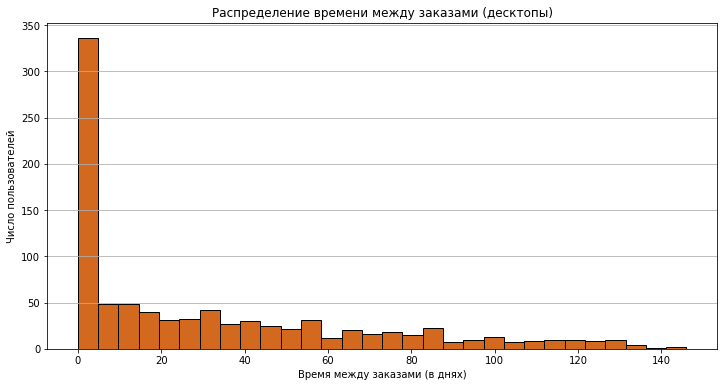

In [74]:
#строим гистограмму распределения
plt.figure(figsize=(12, 6))
plt.hist(desktop_days_since_prev, bins=30, color='#D2691E', edgecolor='black')
plt.title('Распределение времени между заказами (десктопы)')
plt.xlabel('Время между заказами (в днях)')
plt.ylabel('Число пользователей')
plt.grid(axis='y')
plt.show()

Для проверки этой гипотезы так же подходит тест Манна–Уитни, так как:

* в данных присутствуют выбросы (длинный хвост в правой части вплоть до 140+ дней)

* распределение данных не является нормальным (распределение сильно скошено вправо, асимметричное, с длинным хвостом. Большинство пользователей совершают повторные заказы в течение нескольких дней, но встречаются случаи с интервалами в десятки и даже сотни дней)

* сравниваются независимые выборки (мобильные и десктоп-пользователи).


In [75]:
#на каком уровне значимости проверяем гипотезу о равенстве распределений
alpha = 0.05 

mobile_days_since_prev = mobile_clean.groupby('user_id')['days_since_prev'].mean()
desktop_days_since_prev = desktop_clean.groupby('user_id')['days_since_prev'].mean()

#применяем тест Манна — Уитни
stat_mw, p_value_mw = mannwhitneyu(
    mobile_days_since_prev, 
    desktop_days_since_prev, 
    alternative='greater' 
) 

if p_value_mw > alpha:
    print(f'pvalue={p_value_mw} > {alpha}')
    print('Нулевая гипотеза находит подтверждение!')
else:
    print(f'pvalue={p_value_mw} < {alpha}')
    print('Нулевая гипотеза не находит подтверждения!')

pvalue=0.8124986625766982 > 0.05
Нулевая гипотеза находит подтверждение!


По результатам теста нет оснований отвергать нулевую гипотезу, поэтому среднее время между заказами **не отличается** для мобильного приложения и стационарных устройств

## Общий вывод и рекомендации

Для анализа были использованы данные о бронированиях онлайн-билетов за период с 1 июня по 30 октября 2024 года. В датасет вошли данные о заказах, пользователях, устройствах, партнёрах, типах мероприятий и выручке.

**Основные результаты анализа**

**Сезонные изменения**

Осенью количество заказов существенно выросло по сравнению с летом. Произошло перераспределение спроса по типам мероприятий:

* Осенью увеличился интерес к театру и спорту.

* Снизилась доля заказов на концерты, стендапы и мероприятия из категории «другое».

* Увеличился спрос на мероприятия с детским возрастным ограничением (0+, 6+, 12+), что может говорить о смещении в сторону семейного досуга.

* Средняя стоимость билета осенью снизилась в большинстве категорий, вероятно из-за популярности более доступных семейных мероприятий.

**Анализ пользовательской активности (осень 2024):**

* Общее количество заказов и число активных пользователей постоянно росло в течение осени.
* DAU вырос: с ~700 до ~1000-1200.
* Среднее число заказов на пользователя стабильно (около 3), с лёгким ростом.
* Средняя выручка с одного билета показывала снижение к концу периода.
* Обнаружена недельная цикличность: максимум активности — в будни, особенно во вторник и четверг; минимум — в воскресенье.

**Популярные события и партнёры** 

На топ-5 партнёров и регионов приходится более 50% всех заказов.

**Результаты проверки гипотез** 

✅ Среднее количество заказов на пользователя выше у мобильных пользователей — гипотеза подтверждена.

❌ Среднее время между заказами не отличается между мобильными и десктоп-пользователями — нулевая гипотеза не отвергнута, различий нет.

**Рекомендации** 

* Учитывать сезонные предпочтения пользователей: осенью активно развивать театральные и спортивные мероприятия, а также семейные форматы.

* Оптимизировать ценообразование: снижение выручки при росте заказов говорит о необходимости анализа акций и скидок.

* Учитывать недельную цикличность в маркетинговых активностях — активнее продвигать события в начале недели, особенно во вторник и четверг
* Укреплять партнёрство с сервисами, демонстрирующими высокую эффективность (лидеры по доле заказов и выручки одновременно).

* Продолжить анализ различий между пользователями мобильных и стационарных устройств — мобильные дают больше заказов, возможно, стоит оптимизировать UX под них.
